# Chainerでクラスの分類

### データの読み込み

In [109]:
import numpy as np
import pandas as pd

In [110]:
df = pd.read_csv("wine-class.csv")
df.head()

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,1,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,1,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


## 入力変数と教師データ（出力変数）に切り分ける

In [111]:
#df.iloc[行,列]
t = df.iloc[:,0]

In [112]:
x = df.iloc[:,1:]

In [113]:
x.head()

,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


In [114]:
x.shape

(178, 10)

In [115]:
type(x)

pandas.core.frame.DataFrame

In [116]:
#chainerが使えるnumpyの形式に変形する必要がある
type(x.values)

numpy.ndarray

In [117]:
#tはchainerで扱う都合上、１、２、３ではなく０、１、２の形にする必要がある
t = t.values - 1
x = x.values

In [118]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [119]:
x.dtype
t.dtype

dtype('int64')

In [120]:
x = x.astype('f')
t = t.astype('i')

In [121]:
x.dtype

dtype('float32')

In [122]:
t.dtype

dtype('int32')

In [647]:
import chainer
import chainer.functions as F
import chainer.links as L

In [773]:
class NN(chainer.Chain):
    
    #モデルの構造
    #NoneとするとChainer側で入力変数の数を数えてくれる
    #初期値として５、３を入れることが出来る
    def __init__(self, n_mid_units1=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units1)
            self.fc2 = L.Linear(None,n_out)
            #Batch Normalization
            self.bn = L.BatchNormalization(10)
     
    #順伝播
    def __call__(self, x):
        h = self.bn(x)#追記
        h = self.fc1(h)
        h = F.relu(h)#精度を見るためにsigmoid()も使ってみる
        h = self.fc2(h)
        return h

In [774]:
np.random.seed(1)
nn = NN()
#modelの定義
#model宣言時に乱数が発生するためシードを固定する
model = L.Classifier(nn)

## Chainerで使用するデータセットの形式

In [775]:
dataset = list(zip(x, t))

## 訓練データと検証データに分割

In [776]:
import chainer

In [777]:
len(dataset)

178

In [778]:
#学習データを全体の７割として分ける
n_train = int(len(dataset) * 0.7)
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed = 1)

### Optimizerの設定

In [779]:
#Optimizerとはパラメータの最適化のアルゴリズムを選択する
optimizer = chainer.optimizers.SGD() #SGD=確率的勾配降下法#Adom()が一般的

In [780]:
#nn = NN()
#model = L.Classifier(nn)
#modelとの関わりを作る
optimizer.setup(model)

### Iteratorの設定

In [781]:
batchsize = 10

In [782]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat = False, shuffle=False)

### Updaterの設定
-CPU: -1

-GPU: 0

In [783]:
#使用するデバイスの設定をする
from chainer import training

In [784]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

### TrainerとExtensionの設定

In [785]:
from chainer.training import extensions

In [786]:
#エポックの数
epoch = 204

In [787]:
#trainerの宣言
#resultフォルダのwineフォルダを作成し、その中にログを作る
trainer = training.Trainer(updater, (epoch,'epoch'), out = 'result/wine')

#検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

#1エポックごとに（trigger）にtrainデータに対するloss,accuracyとtestデータに対するloss、accuracy経過時間を出力します
trainer.extend(extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy',
                'main/loss','validation/main/loss','elapsed_time']),trigger=(1,'epoch'))

## 学習の実行

In [788]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.415385       0.358333                  1.11046     1.30603               0.0334043     
2           0.475          0.441667                  1.02261     1.03827               0.0682714     
3           0.584615       0.591667                  0.923437    0.928491              0.0991846     
4           0.608333       0.625                     0.863558    0.870106              0.130425      
5           0.641667       0.625                     0.792922    0.822193              0.160953      
6           0.7            0.625                     0.750538    0.773367              0.192139      
7           0.7            0.625                     0.684348    0.730491              0.222177      
8           0.738462       0.625                     0.679364    0.701627              0.253465      
9           0.758333       0.641667                  0.638621    0.674931           

79          0.958333       0.983333                  0.125103    0.105203              2.51938       
80          0.966667       0.983333                  0.128374    0.104404              2.55373       
81          0.946154       0.966667                  0.159379    0.10792               2.58831       
82          0.933333       0.983333                  0.176582    0.105064              2.62023       
83          0.946154       0.966667                  0.176079    0.113073              2.65248       
84          0.966667       0.966667                  0.125922    0.106961              2.68381       
85          0.958333       0.983333                  0.124302    0.101804              2.71665       
86          0.961538       0.983333                  0.099743    0.100577              2.74649       
87          0.933333       0.983333                  0.201685    0.0993586             2.77635       
88          0.976923       0.983333                  0.0806102   0.0983919        

158         0.961538       0.983333                  0.115332    0.071761              5.3547        
159         0.983333       0.983333                  0.0773343   0.0727144             5.39236       
160         0.958333       0.983333                  0.123583    0.0685924             5.43387       
161         0.969231       0.983333                  0.0931418   0.0647741             5.47043       
162         0.966667       0.983333                  0.112064    0.0673435             5.50607       
163         0.961538       0.983333                  0.101377    0.0685055             5.54126       
164         0.983333       0.983333                  0.0574263   0.0655744             5.57678       
165         0.95           0.983333                  0.129942    0.0658972             5.61307       
166         0.953846       0.983333                  0.121838    0.0649481             5.65134       
167         0.958333       0.983333                  0.102689    0.0688349        

### 結果の確認

In [789]:
import json

In [790]:
with open('result/wine/log') as f:
    logs = json.load(f)

In [791]:
results = pd.DataFrame(logs)

In [792]:
results.head()

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.033404,1,13,0.415385,1.110462,0.358333,1.306030
1,0.068271,2,25,0.475000,1.022615,0.441667,1.038274
2,0.099185,3,38,0.584615,0.923437,0.591667,0.928491
3,0.130425,4,50,0.608333,0.863558,0.625000,0.870106
4,0.160953,5,62,0.641667,0.792922,0.625000,0.822193


In [793]:
results_accuracy = results[['main/accuracy', 'validation/main/accuracy']]

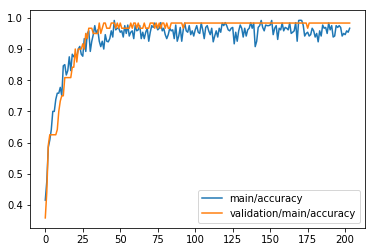

In [794]:
%matplotlib inline
results_accuracy.plot()

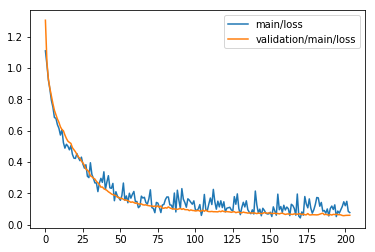

In [795]:
results[['main/loss', 'validation/main/loss']].plot()

In [796]:
results['validation/main/accuracy'].max()

0.9833333293596903

In [798]:
df.iloc[:,1:].head()

,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185
3,14.37,2.50,16.8,113,3.85,3.49,0.24,7.80,0.86,1480
4,13.24,2.87,21.0,118,2.80,2.69,0.39,4.32,1.04,735


### 学習済みモデルの保存

In [799]:
model

In [801]:
!mkdir models

In [803]:
chainer.serializers.save_npz('models/wine.npz', model)

### 学習済みモデルを使用した推論（予測値の計算）

### 学習済みモデルのロード

In [804]:
#モデルの構造を明示する必要がある
model = L.Classifier(NN())

In [806]:
chainer.serializers.load_npz('models/wine.npz', model)

### 予測値の計算
今回は一番最初のサンプルに対する予測値の計算を行う

In [809]:
x_new = x[0]

In [810]:
x_new.shape

(10,)

In [811]:
#予測値の計算
y = model.predictor(1, x_)

InvalidType: 
Invalid operation is performed in: BatchNormalization (Forward)

Expect: in_types[1].ndim == 0
Actual: 1 != 0

`（バッチサイズ,入力変数の数）`という形式でないといけない

In [812]:
x_new = x_new[np.newaxis]

In [814]:
x_new.shape

(1, 10)

In [816]:
y = model.predictor(x_new)

/Users/misuhiroshi/anaconda3/lib/python3.7/site-packages/chainer/functions/normalization/batch_normalization.py:114: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


In [817]:
#足して１になっていないため、足して１の形にする必要がある
y

variable([[ 0.10603426,  0.4671204 , -1.2716975 ]])

In [819]:
#softmax関数を用いて、足して１に形にする
y = F.softmax(y)

In [820]:
y

variable([[0.37215716, 0.5340035 , 0.09383936]])

In [821]:
y.array

array([[0.37215716, 0.5340035 , 0.09383936]], dtype=float32)

In [823]:
np.argmax(y.array)#最大値のindex番号を取り出す

1